In [10]:
from utils.pair_simulator import PairSimulator
import matplotlib.pyplot as plt
import numpy as np
from lsst.ts.wep.wfEstimator import WfEstimator
from lsst.ts.wep.utility import DefocalType, getConfigDir, FilterType
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth
from glob import glob
import pandas as pd
import galsim


In [ ]:
zk_files = glob("/astro/store/epyc/users/jfc20/data/aos_sims/zernikes/*")


In [3]:
df = pd.read_pickle("data/test_dataframe_old.pkl")


In [4]:
wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
wfEst.config(
    sizeInPix=170,
    units="um",
    algo="ml",
    mlFile="/phys/users/jfc20/mlaos2/ml-aos/models/v22_2023-05-23_19:32:30.pt",
)


In [11]:
airmass = 4
simulator = PairSimulator(
    band="g",
    obs={"zenith": np.arccos(1 / airmass) * 180 / np.pi * galsim.degrees},
    atm=True,
    dcr=True,
)


In [14]:
zk_intra_wDCR = []
zk_extra_wDCR = []

zk_intra_woDCR = []
zk_extra_woDCR = []

opd_list = []

for seed in range(100):
    rng = np.random.default_rng(seed)

    corner = rng.choice(["R00", "R40", "R44", "R04"])
    wf_dev = rng.choice(df["zernikes"])

    simulator.set_wf_dev(wf_dev)
    opd_list.append(simulator.get_wf_dev(corner))

    simulator.simulator.dcr_bool = True
    for T in [30_000]:  # np.linspace(4_000, 30_000, 20):
        simulator.set_seed(seed)
        pair = simulator.simulate(
            corner=corner,
            background=0,
            intra_T=T,
            extra_T=T,
        )
        pair.intra.stamp_size = 170
        pair.extra.stamp_size = 170

        wfEst.reset()
        wfEst.setImg(
            pair.intra.angle,
            DefocalType.Intra,
            filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
            image=pair.intra.stamp,
        )
        zk_intra_wDCR.append(wfEst.calWfsErr())

        wfEst.reset()
        wfEst.setImg(
            pair.extra.angle,
            DefocalType.Extra,
            filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
            image=pair.extra.stamp,
        )
        zk_extra_wDCR.append(wfEst.calWfsErr())

    simulator.simulator.dcr_bool = False
    for T in [30_000]:  # np.linspace(4_000, 30_000, 20):
        simulator.set_seed(seed)
        pair = simulator.simulate(
            corner=corner,
            background=0,
            intra_T=T,
            extra_T=T,
        )
        pair.intra.stamp_size = 170
        pair.extra.stamp_size = 170

        wfEst.reset()
        wfEst.setImg(
            pair.intra.angle,
            DefocalType.Intra,
            filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
            image=pair.intra.stamp,
        )
        zk_intra_woDCR.append(wfEst.calWfsErr())

        wfEst.reset()
        wfEst.setImg(
            pair.extra.angle,
            DefocalType.Extra,
            filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
            image=pair.extra.stamp,
        )
        zk_extra_woDCR.append(wfEst.calWfsErr())

zk_intra_wDCR = np.array(zk_intra_wDCR)
zk_extra_wDCR = np.array(zk_extra_wDCR)

zk_intra_woDCR = np.array(zk_intra_woDCR)
zk_extra_woDCR = np.array(zk_extra_woDCR)

opd_list = np.array(opd_list)


NameError: name 'zk_both_wDCR' is not defined

In [16]:
zk_both_wDCR = (zk_intra_wDCR + zk_extra_wDCR) / 2
zk_both_woDCR = (zk_intra_woDCR + zk_extra_woDCR) / 2


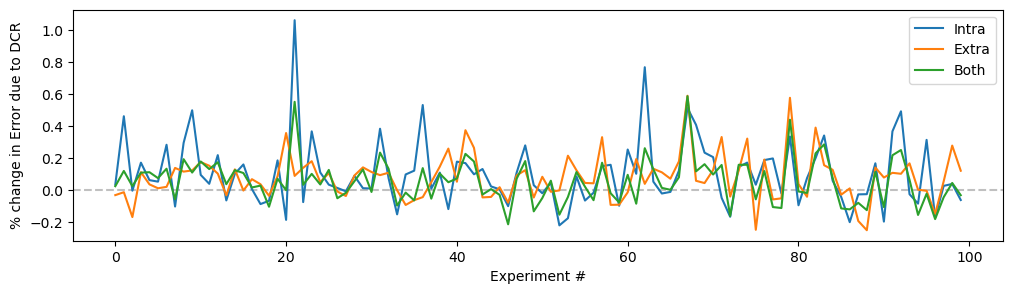

In [17]:
intra_err_woDCR = np.sqrt(
    np.sum(convertZernikesToPsfWidth(zk_intra_woDCR - opd_list) ** 2, axis=1)
)
intra_err_wDCR = np.sqrt(
    np.sum(convertZernikesToPsfWidth(zk_intra_wDCR - opd_list) ** 2, axis=1)
)

extra_err_woDCR = np.sqrt(
    np.sum(convertZernikesToPsfWidth(zk_extra_woDCR - opd_list) ** 2, axis=1)
)
extra_err_wDCR = np.sqrt(
    np.sum(convertZernikesToPsfWidth(zk_extra_wDCR - opd_list) ** 2, axis=1)
)

both_err_woDCR = np.sqrt(
    np.sum(convertZernikesToPsfWidth(zk_both_woDCR - opd_list) ** 2, axis=1)
)
both_err_wDCR = np.sqrt(
    np.sum(convertZernikesToPsfWidth(zk_both_wDCR - opd_list) ** 2, axis=1)
)

de_intra = intra_err_wDCR / intra_err_woDCR - 1
de_extra = extra_err_wDCR / extra_err_woDCR - 1
de_both = both_err_wDCR / both_err_woDCR - 1


fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(de_intra, label="Intra")
plt.plot(de_extra, label="Extra")
plt.plot(de_both, label="Both")
plt.axhline(0, c="silver", ls="--", zorder=0)

plt.legend()
plt.xlabel("Experiment #")
plt.ylabel("% change in Error due to DCR")
plt.show()


In [46]:
(np.median(de_intra) + np.median(de_extra)) / 2, np.median(de_both)


(0.06778176397522989, 0.052501122567411684)

In [47]:
np.std(de_intra), np.std(de_extra), np.std(de_both)


(0.2054199411102146, 0.14201404356257744, 0.13787526670714476)

In [28]:
simulator.simulator.dcr_bool = False
simulator.set_seed(42)
pair_wo_dcr = simulator.simulate(
    corner="R00",
    background=0,
    intra_T=T,
    extra_T=T,
)

simulator.simulator.dcr_bool = True
simulator.set_seed(42)
pair_w_dcr = simulator.simulate(
    corner="R00",
    background=0,
    intra_T=T,
    extra_T=T,
)


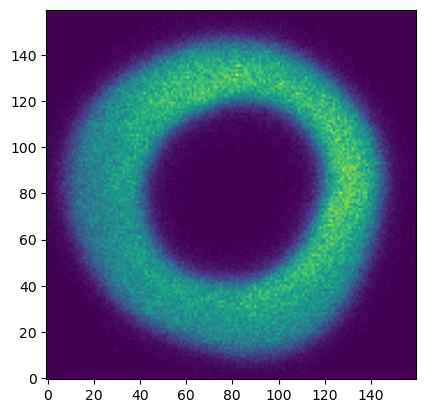

In [37]:
plt.imshow(pair_wo_dcr.intra.stamp, origin="lower")


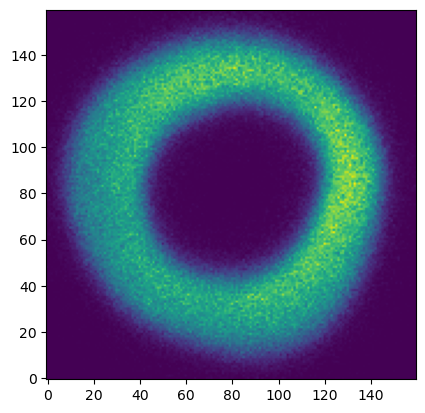

In [38]:
plt.imshow(pair_w_dcr.intra.stamp, origin="lower")


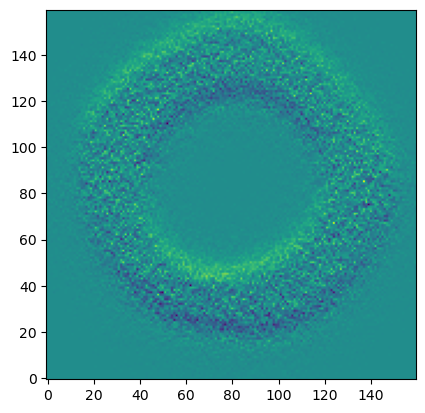

In [39]:
plt.imshow(pair_w_dcr.extra.stamp - pair_wo_dcr.extra.stamp, origin="lower")
